In [1]:
import os,sys
ROOT_DIR = os.path.abspath("../../")
INTERIM_DATA = os.path.join(ROOT_DIR, 'data/interim')
PROCESSED_DATA = os.path.join(ROOT_DIR, 'data/processed')
txt = os.path.join(ROOT_DIR, 'data/processed/keep_img_ids.txt')
sys.path.append(ROOT_DIR)  # To find local version of the library

import shutil


In [33]:
labels ={'sidewalk':8,
            'rail track':10,
            'wall':12,
            'fence':13,
            'guard rail':14,
            'pole':17,
            'polegroup':18,
            'traffic sign': 20,
            'vegetation': 21,
            'car':26}

IMG_DIR = os.path.join(INTERIM_DATA, 'leftImg8bit')
LBL_DIR = os.path.join(INTERIM_DATA, 'gtFine/')

x_train, y_train = IMG_DIR + '/train', LBL_DIR+'train'
# x_test, y_test = IMG_DIR + '/test', LBL_DIR+'/test'
x_val , y_val =IMG_DIR + '/val', LBL_DIR+'val'

In [34]:
with open(txt,'r') as f:
    keep_ids = f.readlines()
    keep_ids = [k[:-1] for k in keep_ids]

In [35]:
# shutil.move('oldname', 'renamedfiles/newname')
# moving everything one level up 
def moveUp(old_directory, new_directory=None, to_keep = None, mask=False):
    for cities in os.listdir(old_directory):
        subdir = os.path.join(old_directory,cities)
        if cities == '.DS_Store':
            continue
        for img in os.listdir(subdir):
            _id = img.split('.')
            if mask and _id[1]!='json':
                continue
            id = "_".join(_id[0].split("_")[:3])
            if id in to_keep:
                img_path = os.path.join(subdir,img)
                if mask:
                    new_path = os.path.join(new_directory,'segmentations',f'{id}.json')
                else:
                    new_path = os.path.join(new_directory,'images',f'{id}.json')
                
                shutil.move(img_path, new_path)         

moveUp(x_train, PROCESSED_DATA, keep_ids)
moveUp(x_val, PROCESSED_DATA, keep_ids)
moveUp(y_train, PROCESSED_DATA, keep_ids,True)
moveUp(y_val, PROCESSED_DATA, keep_ids, True)


In [36]:
# check correct number of items moved
len(os.listdir(PROCESSED_DATA+'/images')) ==len(os.listdir(PROCESSED_DATA+'/segmentations'))

True

In [37]:
IMG_DIR = os.path.join(PROCESSED_DATA, 'images')
LBL_DIR = os.path.join(PROCESSED_DATA, 'segmentations')

In [38]:
import json
def getInstances(filename:str, labelsToKeep:dict):
    labels = []
    keys = labelsToKeep.keys()
    data = json.load(open(filename))
    data = data["objects"]
    for d in data:
        l = d['label']
        if l in keys:
            labels.append(labelsToKeep[l])
    return labels

def getLabels(ids, y_directory,keepLabels=labels):
    labels = []
    for id in ids:
        # city= id.split('_')[0]
        # im_path = os.path.join(x,city,id+'_leftImg8bit.png')
        lb_path = os.path.join(y_directory, id+'.json')
        labels.append(getInstances(lb_path,keepLabels))
    return labels

import pandas as pd
def generateCSV(filepath:str, ids, labels):
    df = pd.DataFrame(data=list(zip(ids, labels)),columns=['ID','LABEL'])
    df.to_csv(filepath, index=False)

In [39]:
# labels = getLabels(keep_ids,LBL_DIR)
# generateCSV(os.path.join(PROCESSED_DATA,'labels.csv'),keep_ids,labels)

In [44]:
from typing import Union
from skimage.draw import polygon
import numpy as np
import matplotlib.pyplot as plt
labels ={'sidewalk':8,
            'rail track':10,
            'wall':12,
            'fence':13,
            'guard rail':14,
            'pole':17,
            'polegroup':18,
            'traffic sign': 20,
            'vegetation': 21,
            'car':26}

def parse_json(filename: str, keep:Union[tuple,list,dict]=labels, return_labels = False):
    polygons = []
    label_n_polygons = {}
    with open(filename) as f:
        data = json.load(f)
        im_h, im_w = data['imgHeight'], data['imgWidth']
        objects = data["objects"]
        for i in objects:
            # print(i['label'])
            if i['label'] in keep:
                
                
                poly_coords = i['polygon']
                tmp = list(zip(*poly_coords))
            # NOTE: The following line assumes that the point coordinates are given as (x,y). 
            #       Change the order of the indices if needed.

                # polygons.append((np.array(tmp[1])-1, np.array(tmp[0])-1))
                polygons.append((np.array(tmp[0]), np.array(tmp[1])))
                if return_labels:
                    if i['label'] not in label_n_polygons:
                        label_n_polygons[i['label']] = []
                    label_n_polygons[i['label']].append(tmp)
    # return (im_h, im_w), labels, polygons
    if return_labels:
        return (im_h,im_w), label_n_polygons
    
    return (im_h, im_w), polygons

# https://stackoverflow.com/questions/72168663/setting-a-list-of-x-y-cooordinates-into-an-array-so-polygons-are-drawn
def draw_instance_Mask(img,poly):
    
    r = poly[0]
    c = poly[1]
    r_index, c_index = polygon(r, c)

    # r_index = [i if i <imgsize[0] else imgsize[0]-1 for i in r_index]
    # c_index = [i if i <imgsize[1] else imgsize[1]-1 for i in c_index]
    # new_index = max(0, min(new_index, len(mylist)-1))

    img[c_index,r_index] = 1
    # return img


def draw_flat_mask(img, polygons):
    for poly in polygons:
        if isinstance(polygons, dict):
            ps = polygons[poly]
            for p in ps:
                draw_instance_Mask(img, p)
        else:
            draw_instance_Mask(img, poly)



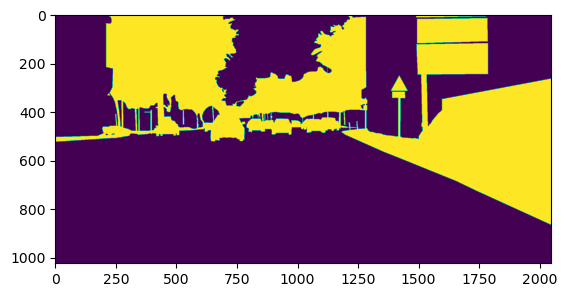

In [45]:
dim, polys = parse_json(LBL_DIR+'/aachen_000005_000019.json',return_labels=True)
im = np.zeros(dim, dtype=np.uint8)
draw_flat_mask(im, polys)
plt.imshow(im)

In [46]:
print('labels in this image:')
for p in polys:
    print(p)

labels in this image:
sidewalk
pole
car
traffic sign
vegetation
wall
fence


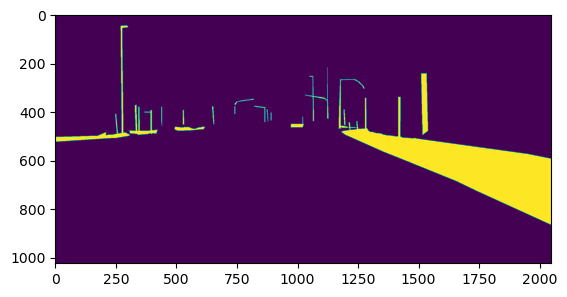

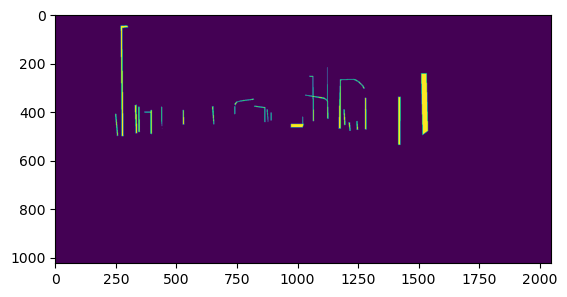

In [61]:
im = np.zeros(dim)
draw_flat_mask(im, polys['pole'])
plt.imshow(im)

0.0025386243609487845


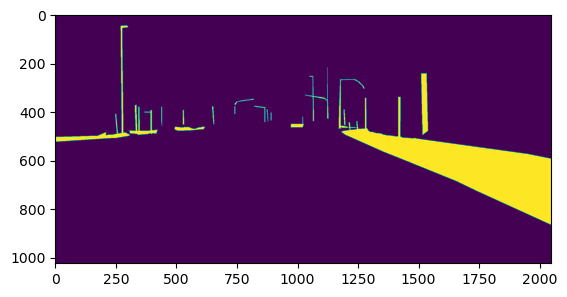

In [63]:
from sklearn.metrics import jaccard_score

sidewalk_mask = np.zeros(dim, dtype=np.uint8)
draw_flat_mask(sidewalk_mask, polys['sidewalk'])

wall_mask = np.zeros(dim, dtype=np.uint8)
draw_flat_mask(wall_mask, polys['wall'])


jac = jaccard_score(sidewalk_mask,wall_mask, average='micro')
print(jac)

s_pole = {'sidewalk':polys['sidewalk'],
          'pole': polys['pole']}
im = np.zeros(dim, dtype=np.uint8)
draw_flat_mask(im, s_pole)
plt.imshow(im)

0.11143649097564588


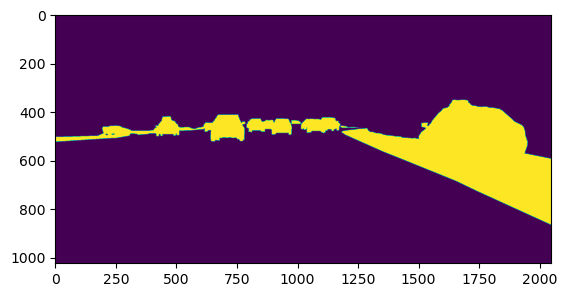

In [58]:
car_mask = np.zeros(dim, dtype=np.uint8)
draw_flat_mask(car_mask, polys['car'])


jac = jaccard_score(sidewalk_mask,car_mask, average='micro')
print(jac)

s_car = {'sidewalk':polys['sidewalk'],
          'car': polys['car']}
im = np.zeros(dim, dtype=np.uint8)
draw_flat_mask(im, s_car)
plt.imshow(im)

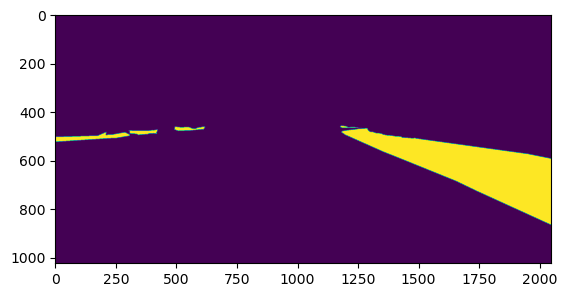

In [59]:
im = np.zeros(dim)
draw_flat_mask(im, polys['sidewalk'])
plt.imshow(im)